<a href="https://colab.research.google.com/github/parviza9999/MSDS462/blob/main/facial_expression_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, concatenate, MaxPooling2D, Add, AveragePooling2D
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten, Activation
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [2]:
#Mounting google drive
from pydrive.drive import GoogleDrive
from google.colab import auth

# Loading Zip Files
import zipfile

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import ast #helps to process trees of the Python abstract syntax grammar.
#import pydicom # for working with DICOM files such as medical images, reports, and radiotherapy objects.
import matplotlib.pyplot as plt
%matplotlib inline
import PIL # Python Imaging Library
from PIL import Image, ImageDraw, ImageFont #Python Imaging Library
import tensorflow as tf

import tensorflow_hub as hub
#import wandb # experiment tracking, dataset versioning, and model management
import seaborn as sns
import tqdm # visualise progress
import cv2 #convert dicom to png

#tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

#sklearn
import sklearn
from sklearn.utils.class_weight import compute_class_weight

In [3]:
import PIL # Python Imaging Library
from PIL import Image, ImageDraw, ImageFont

In [4]:
# Allows for muliple output in one cell window
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = '/content/train'

In [7]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [9]:
#setting up the token
#!pip install --upgrade kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [ ]:
! kaggle datasets download -d msambare/fer2013

 94% 57.0M/60.3M [00:00<00:00, 58.1MB/s]
100% 60.3M/60.3M [00:00<00:00, 82.6MB/s]


In [ ]:
import zipfile
zf = "/content/fer2013.zip"
target_dir = "/content/dataset/fer2013"
zfile = zipfile.ZipFile(zf)
zfile.extractall(target_dir)

In [ ]:
def compack_block(x, filters):
    f1, f2, f3, f4 = filters

    main_path_1 = Conv2D(f1, kernel_size=(1, 1), padding='same', activation=relu)(x)
    main_path_1 = BatchNormalization(axis=3)(main_path_1)
    main_path_1 = Conv2D(f1, kernel_size=(3, 3), padding='same', activation=relu)(main_path_1)

    main_path_2 = Conv2D(f2, kernel_size=(1, 1), padding='same', activation=relu)(x)
    main_path_2 = BatchNormalization(axis=3)(main_path_2)
    main_path_2 = Conv2D(f2, kernel_size=(5, 5), padding='same', activation=relu)(main_path_2)

    shortcut = Conv2D(f3, kernel_size=(1, 1), padding='same', activation=relu)(x)
    shortcut = BatchNormalization(axis=3)(shortcut)

    # first merger
    merger = concatenate([main_path_1, main_path_2, shortcut], axis=3)
#     merger = Conv2D(f4, kernel_size=(3, 3), padding='same', activation=relu)(merger)
    merger = BatchNormalization(axis=3)(merger)

    # second merger
    merger = concatenate([merger, x], axis=3)
    merger = BatchNormalization(axis=3)(merger)

    return merger

In [ ]:
input_layer = Input(shape=(48, 48, 3))

x = Conv2D(filters=128, kernel_size=(5, 5), strides=(1, 1), activation=relu, padding='same')(input_layer)
x = BatchNormalization(axis=3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=relu)(x)
x = BatchNormalization(axis=3)(x)
x = Dropout(0.2)(x)

x = compack_block(x, filters=[64, 96, 128, 128])
x = compack_block(x, filters=[64, 96, 128, 128])

x = Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=relu)(x)
x = BatchNormalization(axis=3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)

x = compack_block(x, filters=[96, 128, 160, 160])
x = compack_block(x, filters=[96, 128, 160, 160])
x = compack_block(x, filters=[96, 128, 160, 160])

x = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=relu)(x)
x = BatchNormalization(axis=3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.4)(x)

x = compack_block(x, filters=[128, 192, 256, 256])
x = compack_block(x, filters=[128, 192, 256, 256])
x = compack_block(x, filters=[128, 192, 256, 256])

x = Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=relu)(x)
x = BatchNormalization(axis=3)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# classifier
x = Flatten()(x)
x = Dense(units=1024, activation=relu)(x)
x = Dropout(0.5)(x)
x = Dense(units=7, activation=softmax)(x)

model = Model(input_layer, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 48, 48, 128)  9728        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 48, 48, 128)  512        ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 24, 128)  0           ['batch_normalization[0][0]']

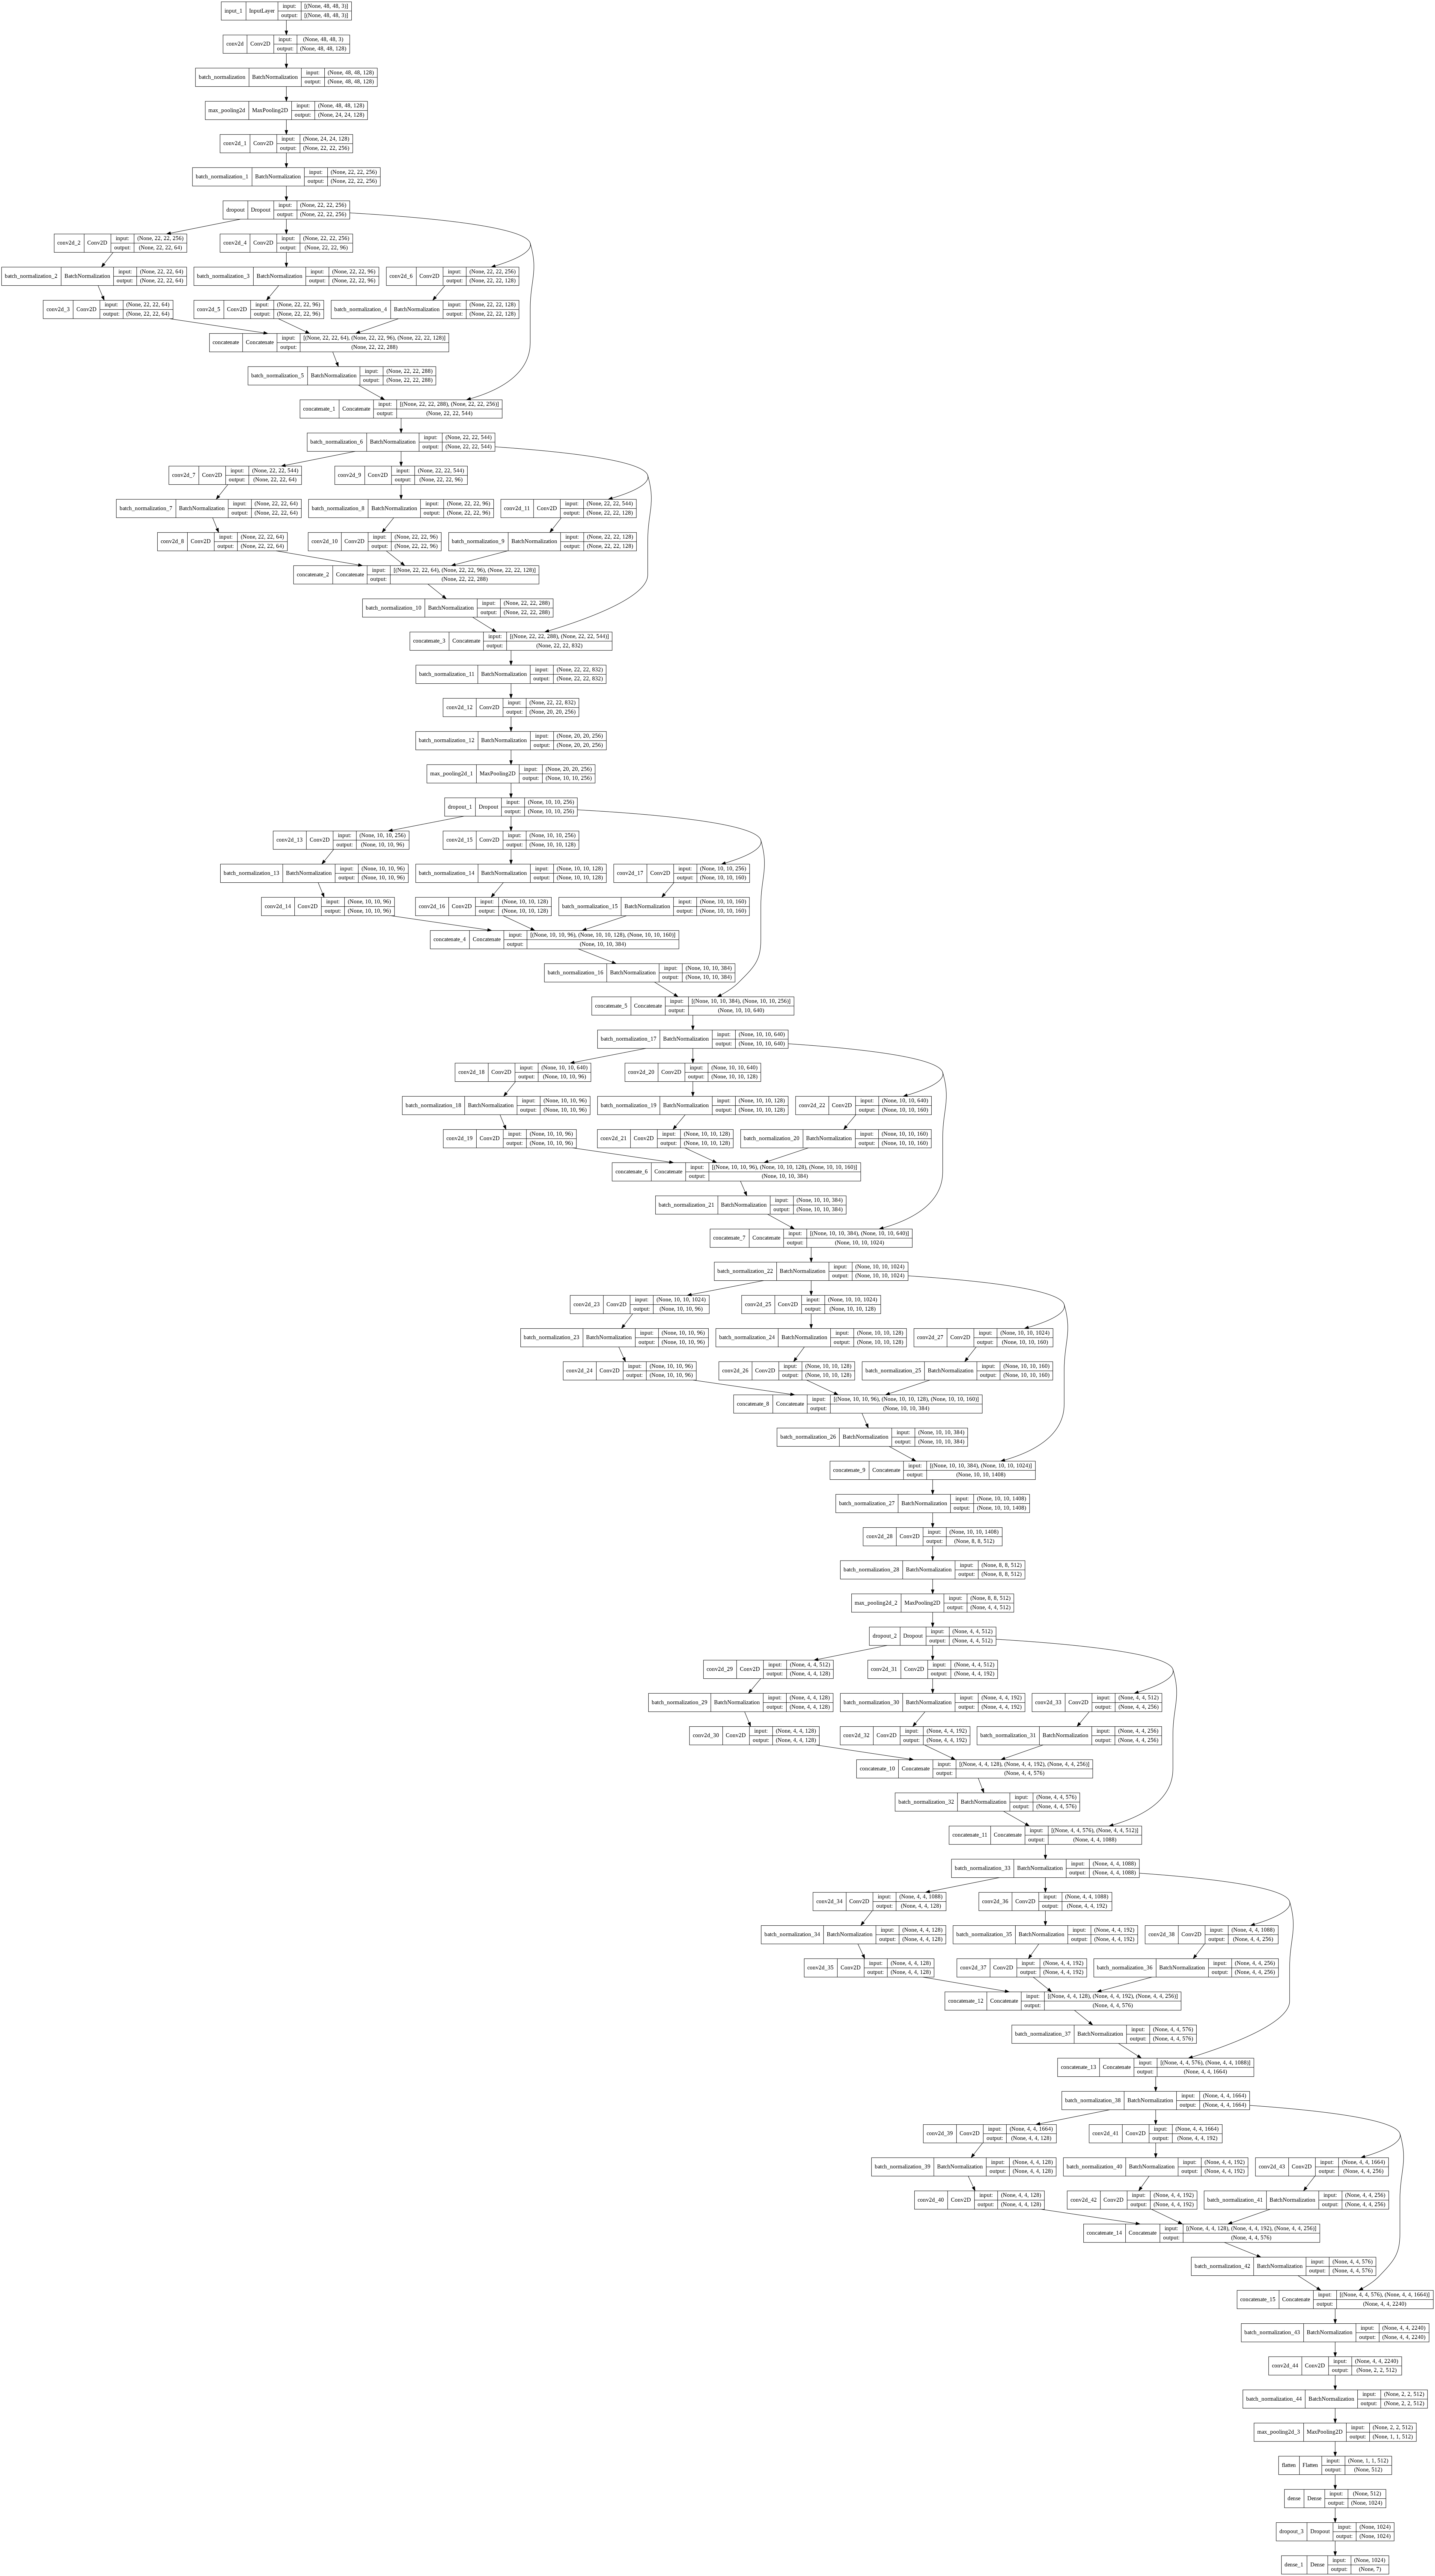

In [ ]:
plot_model(model,
           show_shapes=True,
           show_layer_names=True)

In [ ]:
model.compile(optimizer=Adam(),
              loss=categorical_crossentropy,
              metrics=['accuracy'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=np.sqrt(0.1))

check_point = ModelCheckpoint(filepath='alexNet.hdf5',
                              monitor='val_loss',
                              save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=20,
                           restore_best_weights=True)

callbacks = [reduce_lr, check_point, early_stop]

In [ ]:
#Define Directories for train, test & Validation Set
train_path = '/content/dataset/fer2013/train'
test_path = '/content/dataset/fer2013/test'

In [ ]:
generator = ImageDataGenerator(rescale=1. / 255,
                               rotation_range=45,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               horizontal_flip=True,
                               vertical_flip=True,
                               validation_split=0.2)

test_generator = ImageDataGenerator(rescale=1. / 255)

train_gen = generator.flow_from_directory(train_path,
                                          target_size=(48, 48),
                                          batch_size=128,
                                          subset='training')

validation_gen = generator.flow_from_directory(train_path,
                                               target_size=(48, 48),
                                               batch_size=128,
                                               subset='validation')

test_gen = test_generator.flow_from_directory(test_path,
                                              target_size=(48, 48),
                                              batch_size=128)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
model_history = model.fit(train_gen,
                          epochs=50,
                          callbacks=callbacks,
                          validation_data=validation_gen)

Epoch 1/50
180/180 [==============================] - 804s 4s/step - loss: 2.0533 - accuracy: 0.2129 - val_loss: 1.8257 - val_accuracy: 0.2540 - lr: 0.0010
Epoch 2/50
180/180 [==============================] - 788s 4s/step - loss: 1.8112 - accuracy: 0.2484 - val_loss: 1.8989 - val_accuracy: 0.2550 - lr: 0.0010
Epoch 3/50
180/180 [==============================] - 849s 5s/step - loss: 1.7729 - accuracy: 0.2737 - val_loss: 1.7715 - val_accuracy: 0.2689 - lr: 0.0010
Epoch 4/50
180/180 [==============================] - 796s 4s/step - loss: 1.7405 - accuracy: 0.2894 - val_loss: 1.8418 - val_accuracy: 0.2106 - lr: 0.0010
Epoch 5/50
180/180 [==============================] - 810s 5s/step - loss: 1.7110 - accuracy: 0.3092 - val_loss: 1.7586 - val_accuracy: 0.2764 - lr: 0.0010
Epoch 6/50
180/180 [==============================] - 795s 4s/step - loss: 1.6631 - accuracy: 0.3410 - val_loss: 2.2185 - val_accuracy: 0.2564 - lr: 0.0010
Epoch 7/50
180/180 [==============================] - 805s 4s/st

Text(0.5, 0, 'epoch')

Text(0, 0.5, 'loss')

Text(0.5, 0, 'epoch')

Text(0, 0.5, 'accuracy')

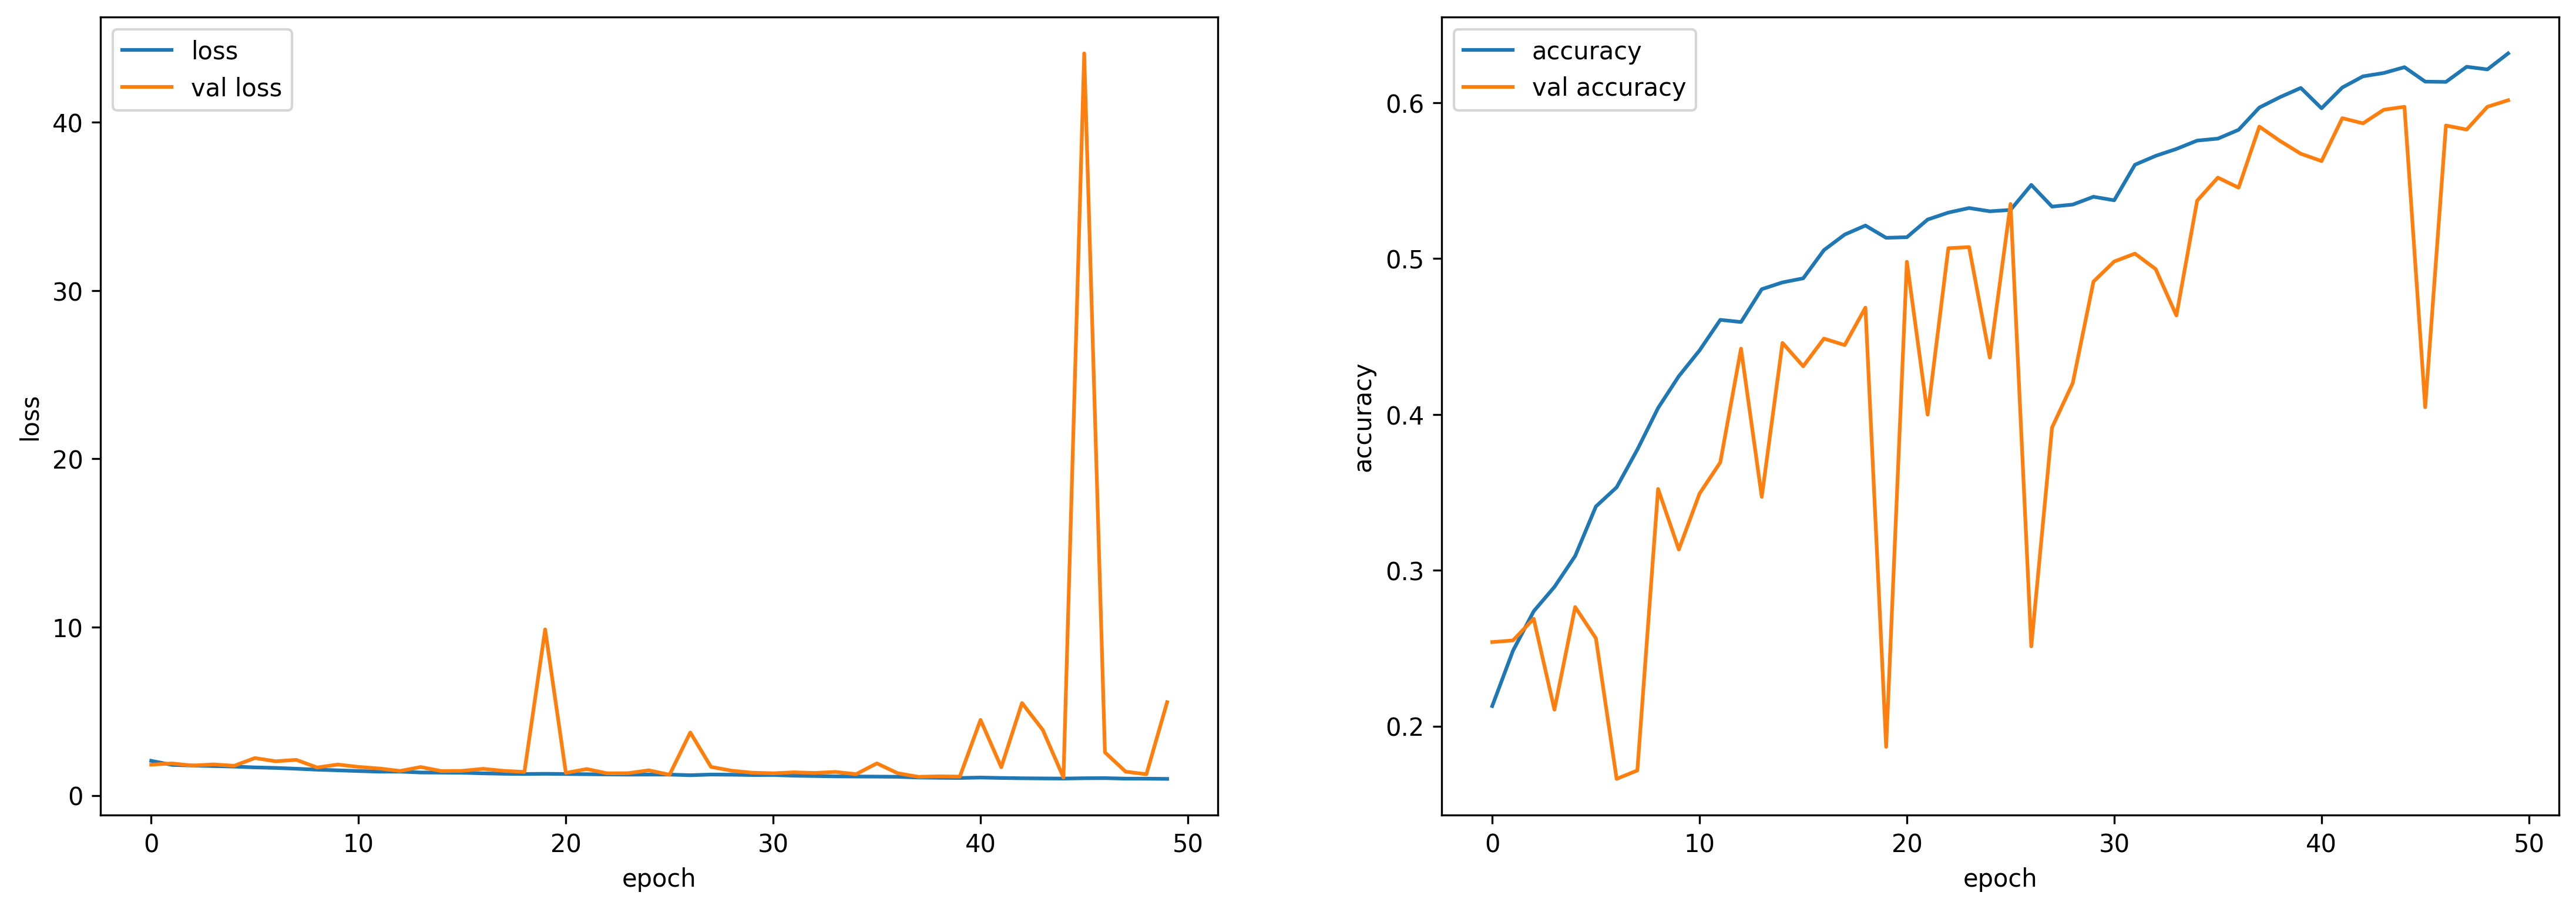

In [ ]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[18, 6], dpi=300)
axes = axes.ravel()
epochs = list(range(len(model_history.history['loss'])))

sns.lineplot(x=epochs, y=model_history.history['loss'], ax=axes[0], label='loss')
sns.lineplot(x=epochs, y=model_history.history['val_loss'], ax=axes[0], label='val loss')
sns.lineplot(x=epochs, y=model_history.history['accuracy'], ax=axes[1], label='accuracy')
sns.lineplot(x=epochs, y=model_history.history['val_accuracy'], ax=axes[1], label='val accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('accuracy')
plt.savefig('plant_train_history.png')
plt.show()

Text(0.5, 0, 'epoch')

Text(0, 0.5, 'learning rate')

Text(0.5, 0, 'learning rate')

Text(0, 0.5, 'accuracy')

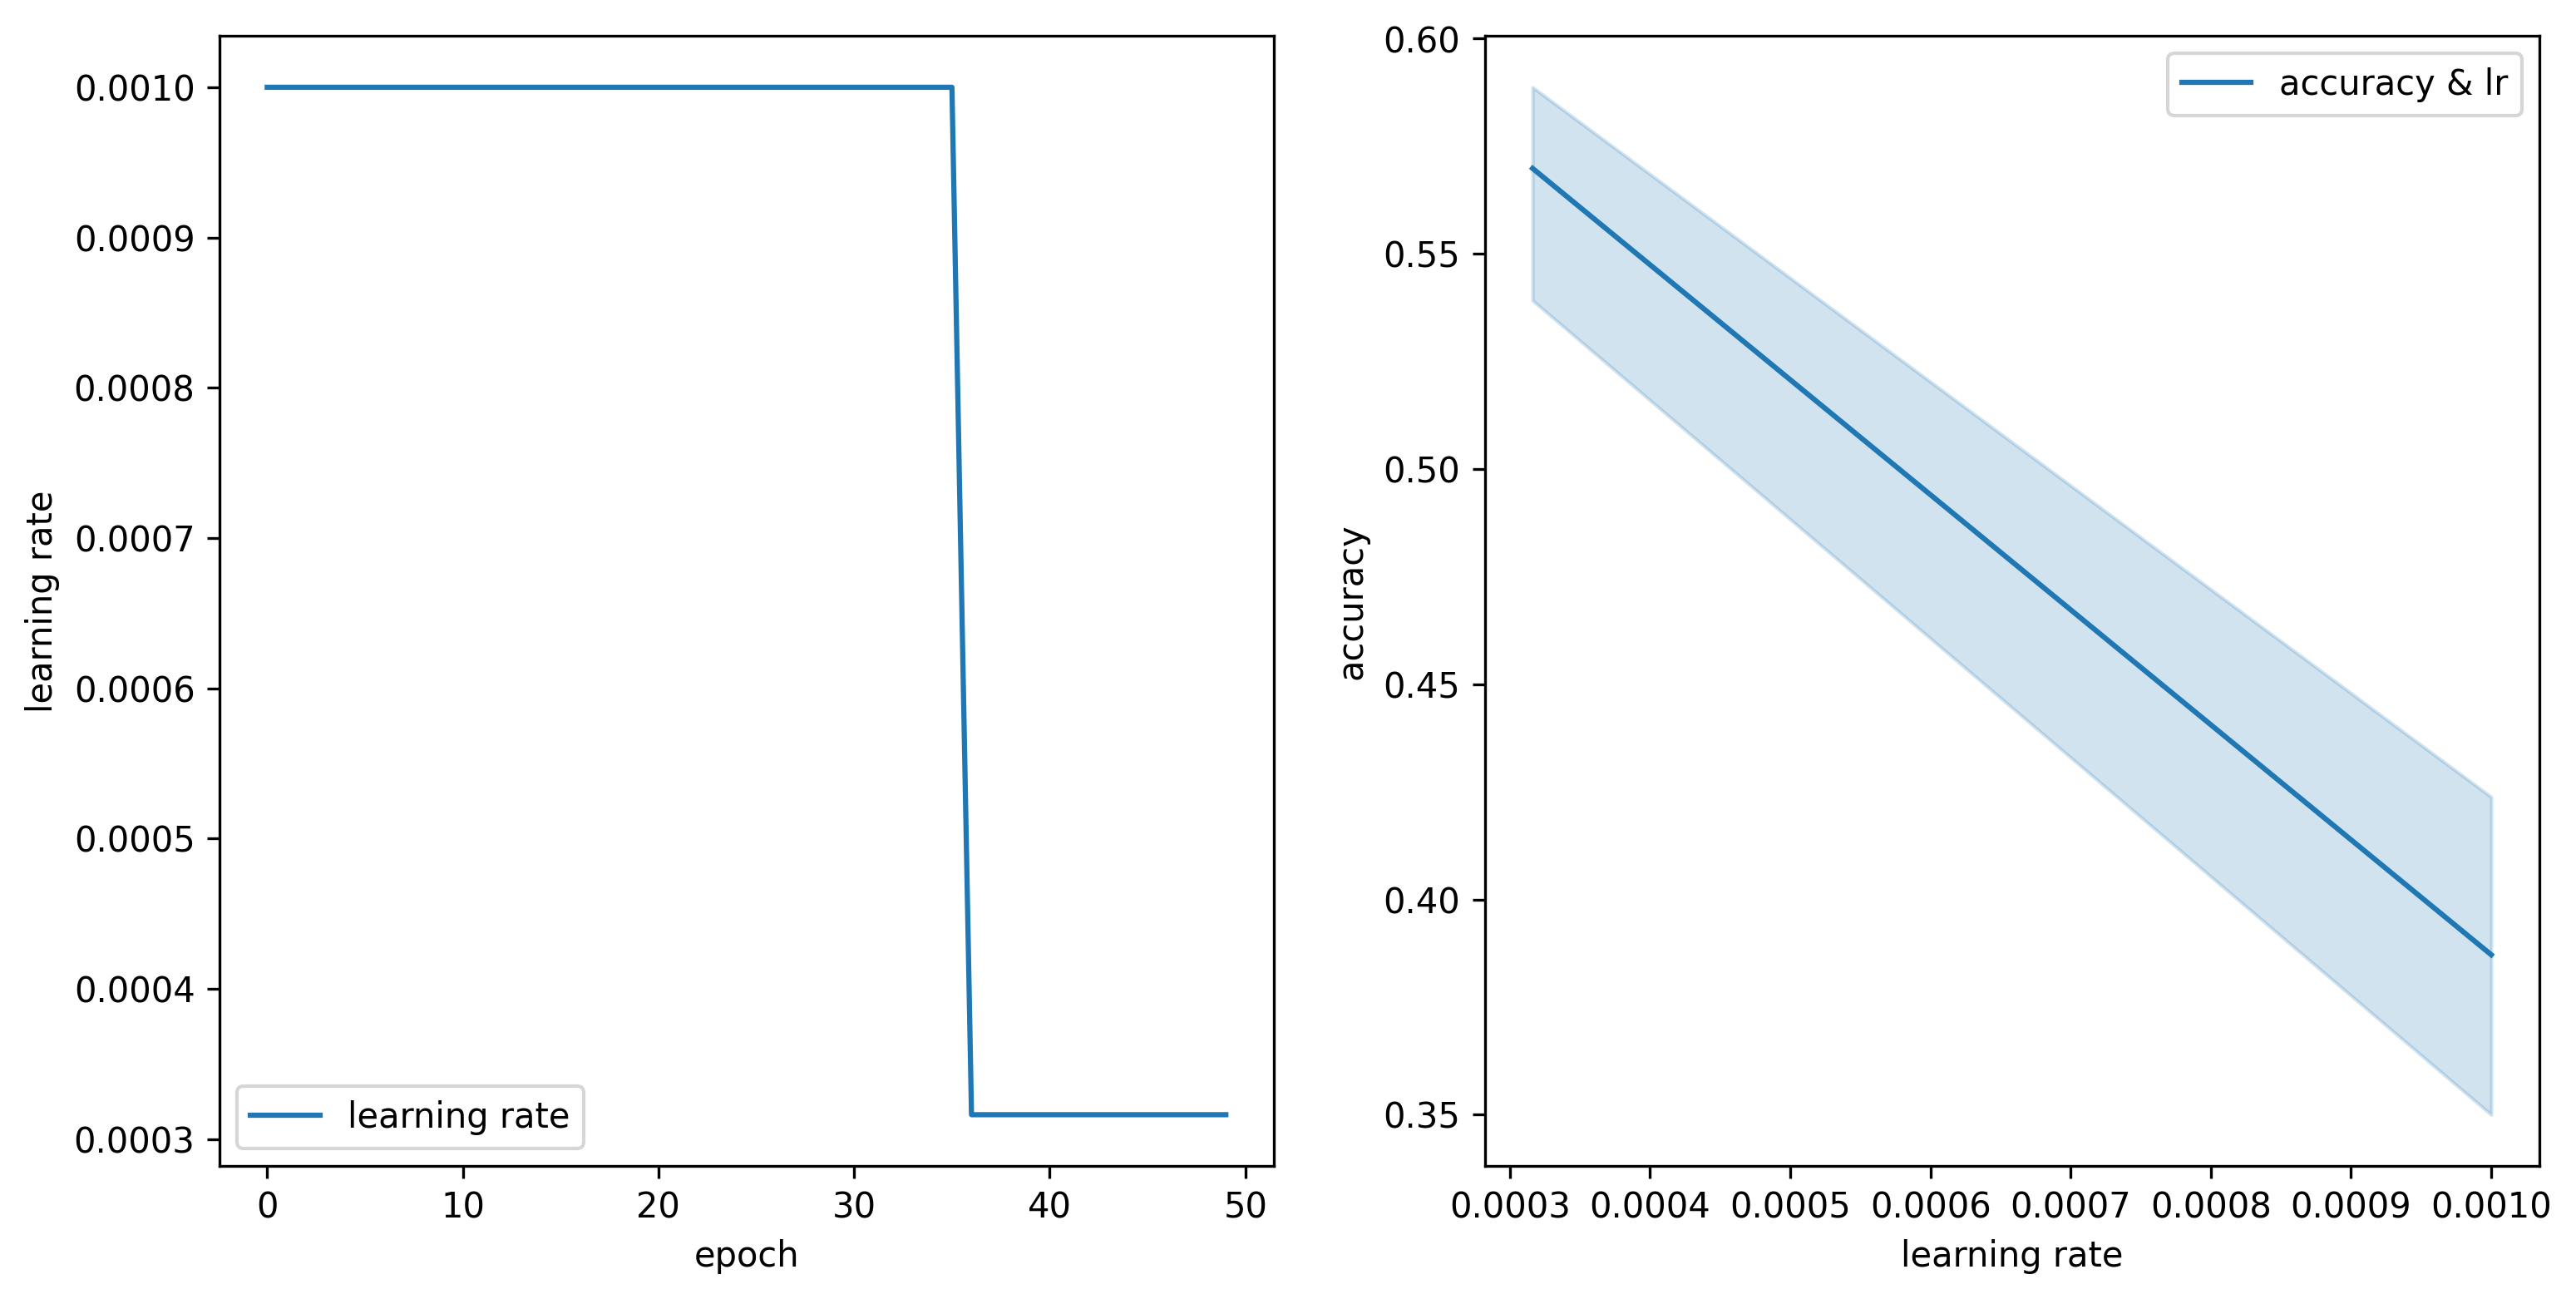

In [ ]:
figure, axes = plt.subplots(nrows=1, ncols=2, figsize=[12, 6], dpi=300)
axes = axes.ravel()

sns.lineplot(x=epochs, y=model_history.history['lr'], ax=axes[0], label='learning rate')
sns.lineplot(x=model_history.history['lr'], y=model_history.history['val_accuracy'], ax=axes[1], label='accuracy & lr')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('learning rate')
axes[1].set_xlabel('learning rate')
axes[1].set_ylabel('accuracy')

plt.savefig('plant_lr_history.png')
plt.show()

In [ ]:
model.evaluate(test_gen)

57/57 [==============================] - 34s 594ms/step - loss: 7.4563 - accuracy: 0.6294


[7.456343173980713, 0.6294232606887817]